# Initial load Complaint

In [20]:
import pandas as pd
import boto3
from io import BytesIO
import gzip
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta, datetime, date

AWS_REGION = 'us-east-1'

s3 = boto3.client('s3')

In [21]:
bucket = "kranio-datalake"
key = "internal/webinar/leoCamilo/raw/complaints.csv"

obj = s3.get_object(Bucket=bucket, Key=key)
obj = BytesIO(obj['Body'].read())

df_source = pd.read_csv(obj)

# Exploratory Analysis

In [22]:
df_source.head()

,Ticket #,Customer Complaint,Date,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone,Description
0,250635,Comcast Cable Internet Speeds,4/22/2015,3:53:50 PM,Internet,Abingdon,Maryland,21009,Closed,No,I have been contacting Comcast Internet Techni...
1,223441,Payment disappear - service got disconnected,4/8/2015,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No,Back in January 2015 I made 2 payments: One fo...
2,242732,Speed and Service,4/18/2015,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes,Our home is located at in Acworth Georgia 3010...
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,5/7/2015,11:59:35 AM,Internet,Acworth,Georgia,30101,Open,Yes,Comcast in the Atlanta area has just put into ...
4,307175,Comcast not working and no service to boot,5/26/2015,1:25:26 PM,Internet,Acworth,Georgia,30101,Solved,No,I have been a customer of Comcast of some sort...


## Age in days for each ticket opened

### Filter Columns

In [23]:
df = df_source[["Ticket #", "Customer Complaint", "Date", "Time", "Status"]]

### Filter only opened tickets

In [24]:
opened_tickets_indexes = df["Status"] == "Open"
df = df[opened_tickets_indexes]

### Convert Date

In [25]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df['Date'] = df['Date'].dt.date

In [26]:
df.head()

,Ticket #,Customer Complaint,Date,Time,Status
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,2015-05-07,11:59:35 AM,Open
9,371214,Comcast Raising Prices and Not Being Available...,2015-06-28,6:46:31 PM,Open
12,339282,Comcast Violating Open Internet Rules by Block...,2015-06-13,4:03:18 PM,Open
23,370538,Comcast monopoly bundling practices,2015-06-27,9:04:34 PM,Open
25,270163,bait and switch,2015-05-02,3:55:24 PM,Open


### Calculate age in days

The dataset has data until 30-06-2015, then we consider the last date as 01-07-2015

In [27]:
last_date = date(2015,7,1)

In [30]:
df_age = last_date - df['Date']
df['age_in_days'] = df_age.dt.days
df.head()

,Ticket #,Customer Complaint,Date,Time,Status,age_in_days
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,2015-05-07,11:59:35 AM,Open,55
9,371214,Comcast Raising Prices and Not Being Available...,2015-06-28,6:46:31 PM,Open,3
12,339282,Comcast Violating Open Internet Rules by Block...,2015-06-13,4:03:18 PM,Open,18
23,370538,Comcast monopoly bundling practices,2015-06-27,9:04:34 PM,Open,4
25,270163,bait and switch,2015-05-02,3:55:24 PM,Open,60


### Order for the oldest opened ticket

In [31]:
df = df.sort_values(by=['age_in_days'], ascending=False)
df.head()

,Ticket #,Customer Complaint,Date,Time,Status,age_in_days
1159,213817,comcast billing shutting off service,2015-04-02,11:23:54 AM,Open,90
757,215802,Unclear policies,2015-04-03,9:22:46 AM,Open,89
1693,234479,interne speed,2015-04-14,12:32:35 PM,Open,78
956,244172,Internet Only Deal,2015-04-20,9:45:51 AM,Open,72
681,244215,Poor service,2015-04-20,10:14:44 AM,Open,72


### Calculate year,month,day from age in days

In [32]:
DAYS_IN_MONTH = 30

def convert_age_in_days(age_in_days):
    year = int(age_in_days / 365)
    month = int((age_in_days % 365) / DAYS_IN_MONTH)
    days = (age_in_days % 365) % DAYS_IN_MONTH
    
    age_in_year_month_day = []
    
    if year:
        age_in_year_month_day.append("%s years" % year)
    
    if month:
        age_in_year_month_day.append("%s months" % month)
    
    if days:
        age_in_year_month_day.append("%s days" % days)
        
    age_in_year_month_day = " ".join(age_in_year_month_day)
    return age_in_year_month_day

df['age_in_year_month_day'] = df['age_in_days'].apply(convert_age_in_days)

df.head()

,Ticket #,Customer Complaint,Date,Time,Status,age_in_days,age_in_year_month_day
1159,213817,comcast billing shutting off service,2015-04-02,11:23:54 AM,Open,90,3 months
757,215802,Unclear policies,2015-04-03,9:22:46 AM,Open,89,2 months 29 days
1693,234479,interne speed,2015-04-14,12:32:35 PM,Open,78,2 months 18 days
956,244172,Internet Only Deal,2015-04-20,9:45:51 AM,Open,72,2 months 12 days
681,244215,Poor service,2015-04-20,10:14:44 AM,Open,72,2 months 12 days


### Group tickets by date

In [33]:
grouped_tickets_by_date = df[["Date", "Ticket #"]].groupby(["Date"], as_index=False)
grouped_tickets_by_date = grouped_tickets_by_date.count()
grouped_tickets_by_date = grouped_tickets_by_date.sort_values(by=['Date'])

grouped_tickets_by_date.head()

,Date,Ticket #
0,2015-04-02,1
1,2015-04-03,1
2,2015-04-14,1
3,2015-04-20,2
4,2015-04-22,2


# Results

In [37]:
df.to_json(orient="records", date_format="iso")

'[{"Ticket #":"213817","Customer Complaint":"comcast billing shutting off service","Date":"2015-04-02T00:00:00.000Z","Time":"11:23:54 AM","Status":"Open","age_in_days":90,"age_in_year_month_day":"3 months"},{"Ticket #":"215802","Customer Complaint":"Unclear policies","Date":"2015-04-03T00:00:00.000Z","Time":"9:22:46 AM","Status":"Open","age_in_days":89,"age_in_year_month_day":"2 months 29 days"},{"Ticket #":"234479","Customer Complaint":"interne speed","Date":"2015-04-14T00:00:00.000Z","Time":"12:32:35 PM","Status":"Open","age_in_days":78,"age_in_year_month_day":"2 months 18 days"},{"Ticket #":"244172","Customer Complaint":"Internet Only Deal","Date":"2015-04-20T00:00:00.000Z","Time":"9:45:51 AM","Status":"Open","age_in_days":72,"age_in_year_month_day":"2 months 12 days"},{"Ticket #":"244215","Customer Complaint":"Poor service","Date":"2015-04-20T00:00:00.000Z","Time":"10:14:44 AM","Status":"Open","age_in_days":72,"age_in_year_month_day":"2 months 12 days"},{"Ticket #":"249466","Custom

### Top 10 oldest Tickets opened

In [34]:
df[["age_in_year_month_day", "Ticket #", "Customer Complaint", "Date", "Time"]].iloc[:10]

,age_in_year_month_day,Ticket #,Customer Complaint,Date,Time
1159,3 months,213817,comcast billing shutting off service,2015-04-02,11:23:54 AM
757,2 months 29 days,215802,Unclear policies,2015-04-03,9:22:46 AM
1693,2 months 18 days,234479,interne speed,2015-04-14,12:32:35 PM
956,2 months 12 days,244172,Internet Only Deal,2015-04-20,9:45:51 AM
681,2 months 12 days,244215,Poor service,2015-04-20,10:14:44 AM
317,2 months 10 days,249466,Never resolved problem with Comcast,2015-04-22,8:45:14 AM
1045,2 months 10 days,250437,Comcast Internet/Cable TV package,2015-04-22,2:46:32 PM
195,2 months 9 days,252877,Comcast Charges,2015-04-23,3:20:54 PM
165,2 months 9 days,252368,I AM BEING CHARGE DOUBLE FOR MY CABLE BILL.,2015-04-23,12:56:29 PM
1901,2 months 7 days,257349,Comcast Internet Service,2015-04-25,8:09:47 PM


### Time series of count of 10 oldest tickets opened

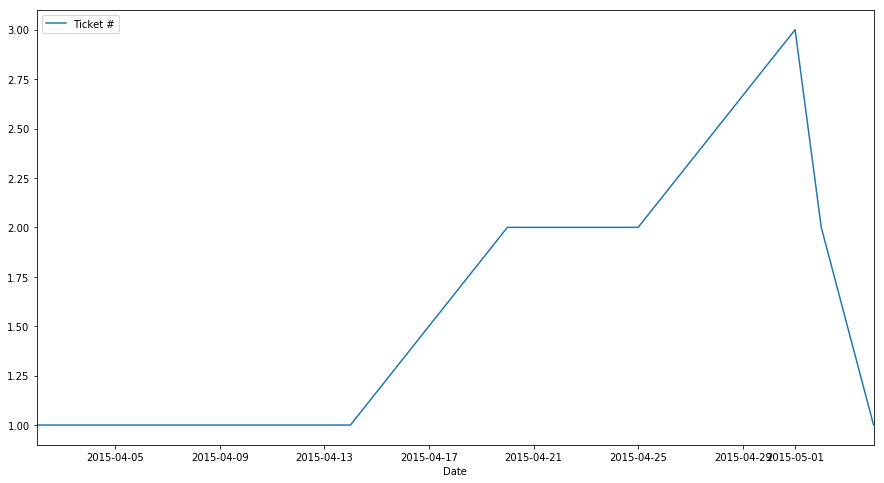

In [35]:
grouped_tickets_by_date.iloc[:10].plot('Date', figsize=(15,8))